In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime

In [3]:
# Import data
flu = pd.read_csv('../data/INFLUENZA_sentinella/data.csv')
weather = pd.read_csv('../data/weather/reg_weather.csv')
google_flu = pd.read_csv('../data/google_search_trend/reg_google_grippe.csv')
google_symptoms = pd.read_csv('../data/google_search_trend/reg_google_fieber_husten.csv')
pop = pd.read_csv('../data/pop_data_cantons/weekly_imputed_pop_data_final.csv')

<h3>Data Preparation</h3>

In [4]:
flu.columns

Index(['valueCategory', 'temporal', 'temporal_type', 'georegion',
       'georegion_type', 'agegroup', 'agegroup_type', 'sex', 'value',
       'popExtrapolation', 'totalConsultationsExtrapolation', 'incValue',
       'prctConsultations', 'prct', 'trend', 'dataComplete'],
      dtype='object')

In [5]:
# Create dataframe for country-level observations, no differentiation between sex or age
flu_CH = flu.query('georegion_type == "country" and agegroup == "all" and sex == "all"').copy()

# Create dataframe for regional observations, no differentiation between sex or age
flu_reg = flu.query('georegion_type == "sentinella_region" and agegroup == "all" and sex == "all"').copy()

# Drop unknown region entries from flu_region using mask
flu_reg = flu_reg[~(flu_reg['georegion'] == 'unknown')]

# Select columns required for analysis
selected_cols = ['temporal', 'georegion', 'popExtrapolation', 'incValue', 'value']
flu_reg = flu_reg[selected_cols]
flu_reg.rename(columns={'popExtrapolation':'flu_cases'}, inplace=True)

In [6]:
# Align time-indexes of google data and flu data
with open('date_dict.json', 'r') as f:
    date_dict = json.load(f)

google_flu['Woche'] = google_flu['Woche'].apply(lambda x: date_dict[x])
google_symptoms['Woche'] = google_symptoms['Woche'].apply(lambda x: date_dict[x])

In [7]:
dates = weather.date.values
# Convert dates to 'YYYY-Www' ISO week format
iso_week_dates = [datetime.strptime(date, '%Y-%m-%d').isocalendar()[:2] for date in dates]
iso_week_dates = [f'{year}-W{week:02d}' for year, week in iso_week_dates]
weather['date'] = iso_week_dates

In [8]:
# Reshape google_flu from wide to long
google_flu = google_flu.melt(id_vars=['Woche'], var_name='region_query', value_name='search_activity')

# Separate region and query information from header into separate rows
google_flu['region'] = google_flu['region_query'].apply(lambda x: "_".join(x.split('_')[:2]))
google_flu['query'] = google_flu['region_query'].apply(lambda x: "_".join(x.split('_')[2:]))
google_flu.drop(columns='region_query', inplace=True) # Drop superfluous region_query column

# Reshape dataframe to get separate columns for each variable
google_flu = google_flu.pivot(index=['Woche', 'region'], columns='query', values='search_activity').reset_index()

In [9]:
# Reshape google_flu from wide to long
google_symptoms = google_symptoms.melt(id_vars=['Woche'], var_name='region_query', value_name='search_activity')

# Separate region and query information from header into separate rows
google_symptoms['region'] = google_symptoms['region_query'].apply(lambda x: "_".join(x.split('_')[:2]))
google_symptoms['query'] = google_symptoms['region_query'].apply(lambda x: "_".join(x.split('_')[2:]))
google_symptoms.drop(columns='region_query', inplace=True) # Drop superfluous region_query column

# Reshape dataframe to get separate columns for each variable
google_symptoms = google_symptoms.pivot(index=['Woche', 'region'], columns='query', values='search_activity').reset_index()

In [10]:
merged_data = pd.merge(flu_reg, weather, how='left', left_on=['temporal', 'georegion'], right_on=['date', 'region']).sort_values(by=['georegion', 'temporal'])
merged_google = pd.merge(google_flu, google_symptoms, how='inner', on=['region', 'Woche'])
merged_data = pd.merge(merged_data, merged_google, how='left', left_on=['georegion', 'temporal'], right_on=['region', 'Woche'])

In [11]:
merged_data.columns

Index(['temporal', 'georegion', 'flu_cases', 'incValue', 'value', 'region_x',
       'date', 'weighted_avg_daily_temp', 'weighted_avg_daily_hum',
       'weighted_max_daily_temp', 'weighted_min_daily_temp',
       'weighted_max_daily_hum', 'weighted_min_daily_hum', 'Woche', 'region_y',
       'Flu', 'Flu_resid', 'Flu_seasonal', 'Flu_trend', 'Grippe',
       'Grippe_resid', 'Grippe_seasonal', 'Grippe_trend', 'Influenza',
       'Influenza_resid', 'Influenza_seasonal', 'Influenza_trend', 'influenza',
       'influenza_resid', 'influenza_seasonal', 'influenza_trend', 'Fieber',
       'Fieber_resid', 'Fieber_seasonal', 'Fieber_trend', 'fièvre',
       'fièvre_resid', 'fièvre_seasonal', 'fièvre_trend', 'husten',
       'husten_resid', 'husten_seasonal', 'husten_trend', 'toux', 'toux_resid',
       'toux_seasonal', 'toux_trend'],
      dtype='object')

In [12]:
merged_data.drop(columns=['region_x', 'region_y', 'date', 'Woche'], inplace=True)

In [13]:
import datetime

# Functions taken from: https://stackoverflow.com/questions/304256/whats-the-best-way-to-find-the-inverse-of-datetime-isocalendar
def iso_year_start(iso_year):
    "The gregorian calendar date of the first day of the given ISO year"
    fourth_jan = datetime.date(iso_year, 1, 4)
    delta = datetime.timedelta(fourth_jan.isoweekday()-1)
    return fourth_jan - delta 

def iso_to_gregorian(iso_year, iso_week, iso_day):
    "Gregorian calendar date for the given ISO year, week and day"
    year_start = iso_year_start(iso_year)
    return year_start + datetime.timedelta(days=iso_day-1, weeks=iso_week-1)


In [14]:
# Define the regex pattern
pattern = r'W(\d{1,2})'

# Extract week number and year and convert to integer
merged_data['week_number'] = merged_data['temporal'].str.extract(pattern).astype(int)

merged_data['year'] = merged_data['temporal'].apply(lambda x: x.split('-')[0])
merged_data['year'] = pd.to_numeric(merged_data['year'])

# Convert from iso-calendar week to dates
merged_data['date'] = list(map(lambda year, week: iso_to_gregorian(year, week, 4), merged_data['year'], merged_data['week_number']))

In [15]:
# merged_data.set_index('date', inplace=True)

In [16]:
# Impute missing values in March 2020 linearly
merged_data['incValue'].interpolate(inplace=True)

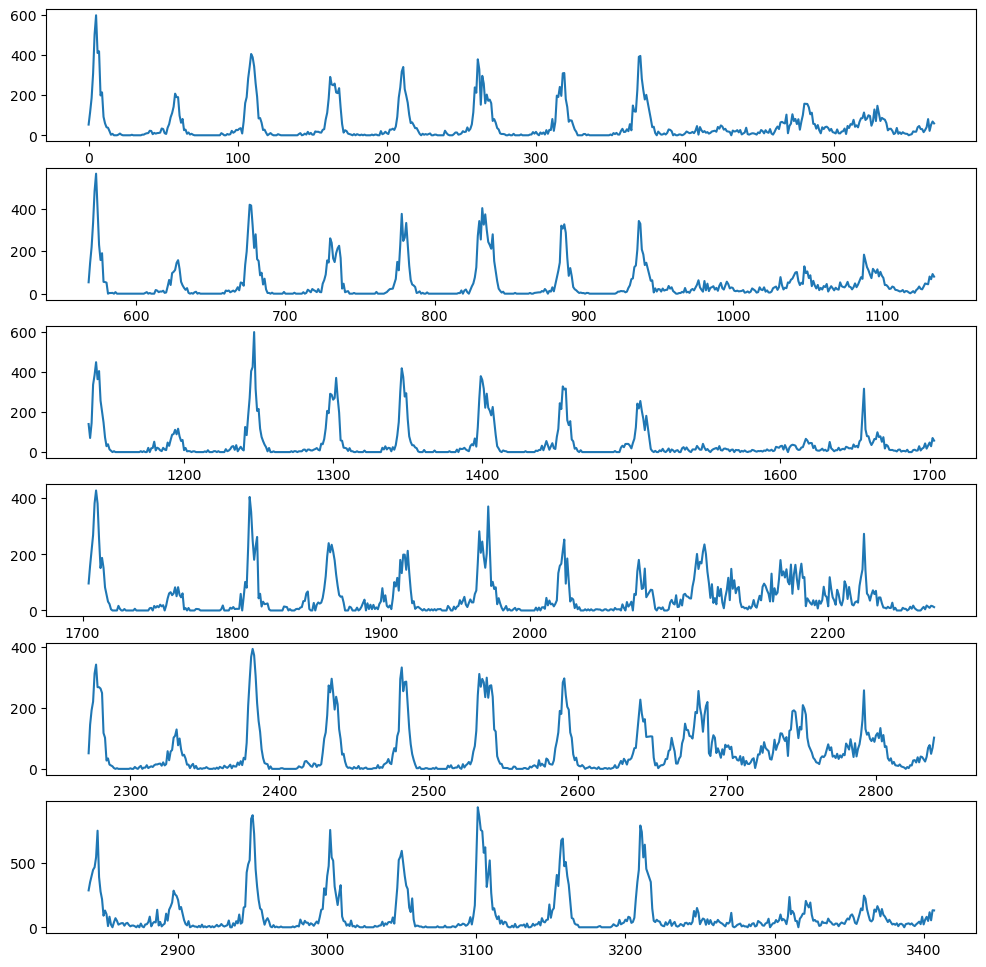

In [17]:
fig, ax = plt.subplots(6, figsize=(12, 12))
for i in range(1, 7):
    ax[i-1].plot(merged_data.loc[merged_data['georegion'] == f"region_{i}", 'incValue'])

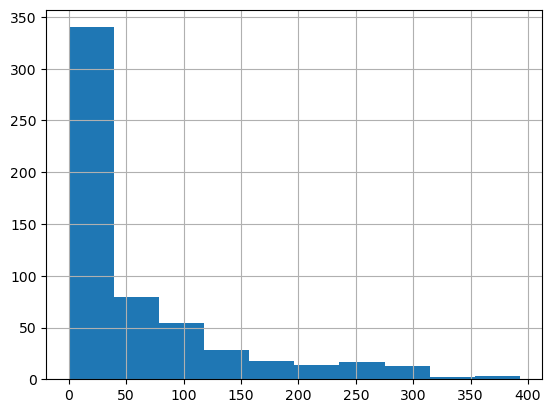

In [18]:
from matplotlib import pyplot
merged_data.loc[merged_data['georegion'] == "region_5", 'incValue'].hist()
pyplot.show()

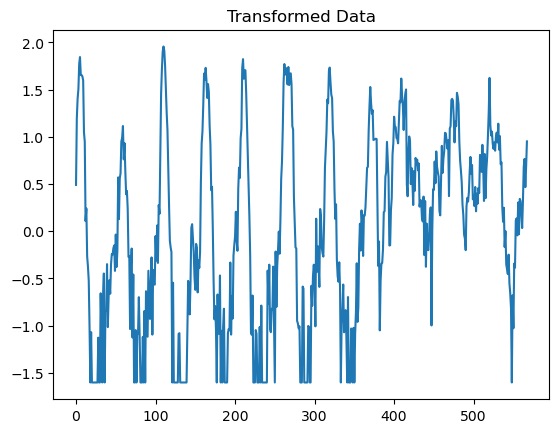

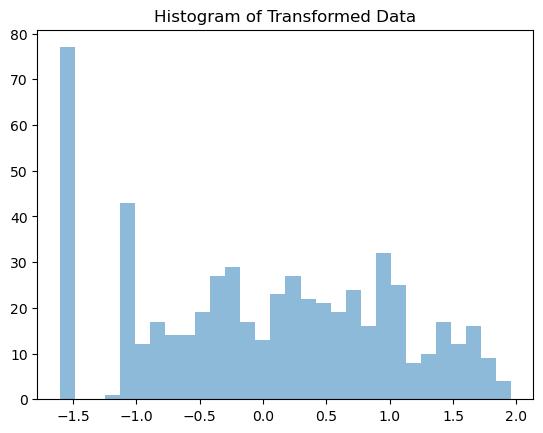

In [19]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer

# Assuming you have imported your dataset and stored it in merged_data

# Create the PowerTransformer with 'yeo-johnson' method
boxcox_transformer = PowerTransformer(method='yeo-johnson')

# Filter and select the data based on the 'georegion' condition and 'incValue' column
filtered_data = merged_data.loc[merged_data['georegion'] == "region_5", 'incValue']

# Fit and transform the filtered data
transformed_data = boxcox_transformer.fit_transform(filtered_data.values.reshape(-1, 1))

# Create a figure and axis for the transformed data
fig1, ax1 = plt.subplots()
ax1.plot(transformed_data)
ax1.set_title('Transformed Data')

# Create a figure and axis for the histogram of transformed data
fig2, ax2 = plt.subplots()
ax2.hist(transformed_data, bins=30, alpha=0.5)
ax2.set_title('Histogram of Transformed Data')

# Show the plots
plt.show()


<h3>Feature Engineering</h3>

In [20]:
# from sklearn.neural_network import MLPRegressor
# from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.metrics import mean_squared_error

In [21]:
# def autoregressive_iterative_forecast(model, initial_input, n_steps):
#     """
#     Perform iterative forecasting using an autoregressive model.

#     Args:
#         model: Trained autoregressive model (e.g., MLPRegressor).
#         initial_input: The initial input features (e.g., the last observation from the training set).
#         n_steps: Number of future time steps to forecast.

#     Returns:
#         A list of forecasts, one for each future time step.
#     """
#     current_input = initial_input.copy()
#     forecasts = []

#     for _ in range(n_steps):
#         # Predict the next step
#         next_step_pred = model.predict(current_input.reshape(1, -1))[0]
#         forecasts.append(next_step_pred)

#         # Update the current input to include the new prediction
#         current_input = np.roll(current_input, -1)
#         current_input[-1] = next_step_pred

#     return np.array(forecasts)


In [22]:
# def create_lagged_features(df, column, number_of_lags=4, seasonal_lags=[52]):
#     # Define a helper function to apply within each group
#     def add_lags(group):
#         # Create a dictionary for the lagged features
#         lags = {f'lag_{i}': group[column].shift(i) for i in range(1, number_of_lags + 1)}
#         for seasonal_lag in seasonal_lags:
#             lags.update({f'seasonal_lag_{i}': group[column].shift(i) for i in range(seasonal_lag - 2, seasonal_lag + 3)})
#         # Return the original column along with the lagged features
#         return pd.concat([group[column], pd.DataFrame(lags, index=group.index)], axis=1)

#     # Group by 'georegion' and apply the lagging within each group
#     new_df = df.groupby('georegion', group_keys=False).apply(add_lags)

#     # Reset index to flatten the dataframe structure after grouping
#     new_df.reset_index(drop=True, inplace=True)

#     return new_df


# data = merged_data.loc[(merged_data['georegion'] == "region_5") & (merged_data['date'].apply(lambda x: x.year < 2020))]

# df_lagged = create_lagged_features(data, column='incValue')
# df_lagged.dropna(inplace=True)
# training_cols = [col for col in df_lagged.columns if 'lag_' in col]
# X = df_lagged[training_cols]
# y = df_lagged['incValue']

In [23]:
# def create_lagged_features(df, column, number_of_lags=4):
#     # Define a helper function to apply within each group
#     def add_lags(group):
#         # Create a dictionary for the lagged features
#         lags = {f'lag_{i}': group[column].shift(i) for i in range(1, number_of_lags + 1)}
#         # Return the original column along with the lagged features
#         return pd.concat([group[column], pd.DataFrame(lags, index=group.index)], axis=1)

#     # Group by 'georegion' and apply the lagging within each group
#     new_df = df.groupby('georegion', group_keys=False).apply(add_lags)

#     # Reset index to flatten the dataframe structure after grouping
#     new_df.reset_index(drop=True, inplace=True)

#     return new_df

# data = merged_data.loc[(merged_data['georegion'] == "region_5") & (merged_data['date'].apply(lambda x: x.year < 2020))]

# df_lagged = create_lagged_features(data, column='incValue')
# df_lagged.dropna(inplace=True)
# training_cols = [col for col in df_lagged.columns if 'lag_' in col]
# X = df_lagged[training_cols]
# y = df_lagged['incValue']


<h3>Backups of the first versions</h3>

In [24]:
# data = merged_data.loc[(merged_data['georegion'] == "region_5") & (merged_data['date'].apply(lambda x: x.year < 2020))]

# # Define parameter configurations to assess
# lags = 51 # Autoregressive lags to consider
# hidden_layer_sizes = [(32,), (32, 32)]
# alphas = [0.0001, 0.001, 0.01] # Regularization parameter
# batch_sizes = [32]
# learning_rates = [0.001, 0.01]
# activations = ['relu']
# seasonal = [[52]]

# models_count = (lags-30) * len(hidden_layer_sizes) * len(alphas) * len(batch_sizes) * len(learning_rates) * len(activations) * len(seasonal)

# i = 0
# scores_df = pd.DataFrame(columns=['RMSE', 'lags', 'seasonal_lags', 'hidden_layers', 'alpha', 'batch_size', 'activation', 'learning_rate'])
# # Grid search hyperparameter configurations
# for lag in range(30, lags):
#     for seasonal_lags in seasonal:
#         # Create lagged features
#         df_lagged = create_lagged_features(data, column='incValue', number_of_lags=lags, seasonal_lags=seasonal_lags)
#         df_lagged.dropna(inplace=True)
#         training_cols = [col for col in df_lagged.columns if 'lag_' in col]
#         X = df_lagged[training_cols]
#         y = df_lagged['incValue']

#         # Split the data
#         split = int(len(y) * 0.8)
#         X_train, X_test = X[:split], X[split:]
#         y_train, y_test = y[:split], y[split:]

#         # Scale the inputs
#         scaler_X = MinMaxScaler()
#         X_train_scaled = scaler_X.fit_transform(X_train)
#         X_test_scaled = scaler_X.transform(X_test)  # Use the same scaler as for X_train

#         # Scale the target
#         scaler_y = MinMaxScaler()
#         y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()  # Reshape to 1D array
#         y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()        # Reshape to 1D array

#         # Keep track of configurations and cv scores

#         for hidden_layers in hidden_layer_sizes:
#             for learning_rate in learning_rates:
#                 for activation in activations:
#                     for alpha in alphas:
#                         for batch_size in batch_sizes:
#                             model = MLPRegressor(max_iter=1000, 
#                                                 random_state=42, 
#                                                 solver='adam', 
#                                                 activation=activation, 
#                                                 hidden_layer_sizes=hidden_layers, 
#                                                 alpha=alpha, 
#                                                 batch_size=batch_size, 
#                                                 learning_rate_init=learning_rate,
#                                                 early_stopping=True, 
#                                                 validation_fraction=0.1, 
#                                                 n_iter_no_change=100,
#                                                 tol=1e-3)
#                             scores = []
#                             tscv = TimeSeriesSplit(n_splits=3)
#                             for train_index, val_index in tscv.split(X_train):
#                                 # Create rolling windows
#                                 X_train_cv, X_val = X_train_scaled[train_index], X_train_scaled[val_index]
#                                 y_train_cv, y_val = y_train_scaled[train_index], y_train_scaled[val_index]
                                
#                                 # Fit model
#                                 model.fit(X_train_cv, y_train_cv)
                                
#                                 predictions = autoregressive_iterative_forecast(model, X_train_cv[-1], len(y_val))
                                
#                                 rmse = mean_squared_error(y_val, predictions, squared=False)
#                                 scores.append(rmse)
                            
#                             # Fill in parameters and score for each configuration 
#                             scores_df.loc[i, 'lags'] = lag
#                             scores_df.loc[i, 'seasonal_lags'] = seasonal_lags
#                             scores_df.loc[i, 'hidden_layers'] = hidden_layers
#                             scores_df.loc[i, 'alpha'] = alpha
#                             scores_df.loc[i, 'batch_size'] = batch_size
#                             scores_df.loc[i, 'activation'] = activation
#                             scores_df.loc[i, 'learning_rate'] = learning_rate
#                             scores_df.loc[i, 'RMSE'] = np.mean(scores)
#                             print(f'{i}/{models_count}: {(i/models_count)*100:.2f}%')
#                             i += 1

In [25]:
# data = merged_data.loc[(merged_data['georegion'] == "region_5") & (merged_data['date'].apply(lambda x: x.year < 2020))]

# # Define parameter configurations to assess
# lags = 51 # Autoregressive lags to consider
# hidden_layer_sizes = [(32,), (32, 32)]
# alphas = [0.0001, 0.001, 0.01] # Regularization parameter
# batch_sizes = [32]
# learning_rates = [0.001, 0.01]
# activations = ['relu']
# seasonal = [[52]]

# models_count = (lags-30) * len(hidden_layer_sizes) * len(alphas) * len(batch_sizes) * len(learning_rates) * len(activations) * len(seasonal)

# i = 0
# scores_df = pd.DataFrame(columns=['RMSE', 'lags', 'seasonal_lags', 'hidden_layers', 'alpha', 'batch_size', 'activation', 'learning_rate'])
# # Grid search hyperparameter configurations
# for lag in range(30, lags):
#     # Create lagged features
#     df_lagged = create_lagged_features(data, column='incValue', number_of_lags=lags, seasonal_lags=seasonal_lags)
#     df_lagged.dropna(inplace=True)
#     training_cols = [col for col in df_lagged.columns if 'lag_' in col]
#     X = df_lagged[training_cols]
#     y = df_lagged['incValue']

#     # Split the data
#     split = int(len(y) * 0.8)
#     X_train, X_test = X[:split], X[split:]
#     y_train, y_test = y[:split], y[split:]

#     # Scale the inputs
#     scaler_X = MinMaxScaler()
#     X_train_scaled = scaler_X.fit_transform(X_train)
#     X_test_scaled = scaler_X.transform(X_test)  # Use the same scaler as for X_train

#     # Scale the target
#     scaler_y = MinMaxScaler()
#     y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()  # Reshape to 1D array
#     y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()        # Reshape to 1D array

#     # Keep track of configurations and cv scores

#     for hidden_layers in hidden_layer_sizes:
#         for learning_rate in learning_rates:
#             for activation in activations:
#                 for alpha in alphas:
#                     for batch_size in batch_sizes:
#                         model = MLPRegressor(max_iter=1000, 
#                                             random_state=42, 
#                                             solver='adam', 
#                                             activation=activation, 
#                                             hidden_layer_sizes=hidden_layers, 
#                                             alpha=alpha, 
#                                             batch_size=batch_size, 
#                                             learning_rate_init=learning_rate,
#                                             early_stopping=True, 
#                                             validation_fraction=0.1, 
#                                             n_iter_no_change=100,
#                                             tol=1e-3)
#                         scores = []
#                         tscv = TimeSeriesSplit(n_splits=3)
#                         for train_index, val_index in tscv.split(X_train):
#                             # Create rolling windows
#                             X_train_cv, X_val = X_train_scaled[train_index], X_train_scaled[val_index]
#                             y_train_cv, y_val = y_train_scaled[train_index], y_train_scaled[val_index]
                            
#                             # Fit model
#                             model.fit(X_train_cv, y_train_cv)
#                             predictions = []
#                             for t in range(len(y_val)):
#                                 one_step_prediction = autoregressive_iterative_forecast(model, X_train_cv[-1] if t == 0 else X_val[t-1], 1)
#                                 predictions.append(one_step_prediction)
                            
#                             rmse = mean_squared_error(y_val, predictions, squared=False)
#                             scores.append(rmse)
                        
#                         # Fill in parameters and score for each configuration 
#                         scores_df.loc[i, 'lags'] = lag
#                         scores_df.loc[i, 'seasonal_lags'] = seasonal_lags
#                         scores_df.loc[i, 'hidden_layers'] = hidden_layers
#                         scores_df.loc[i, 'alpha'] = alpha
#                         scores_df.loc[i, 'batch_size'] = batch_size
#                         scores_df.loc[i, 'activation'] = activation
#                         scores_df.loc[i, 'learning_rate'] = learning_rate
#                         scores_df.loc[i, 'RMSE'] = np.mean(scores)
#                         print(f'{i}/{models_count}: {(i/models_count)*100:.2f}%')
#                         i += 1

In [26]:
# NOTE BACKUP
# def autoregressive_iterative_forecast(model, initial_input, n_steps):
#     """
#     Perform iterative forecasting using an autoregressive model.

#     Args:
#         model: Trained autoregressive model (e.g., MLPRegressor).
#         initial_input: The initial input features (e.g., the last observation from the training set).
#         n_steps: Number of future time steps to forecast.

#     Returns:
#         A list of forecasts, one for each future time step.
#     """
#     current_input = initial_input.copy()
#     forecasts = []

#     for _ in range(n_steps):
#         # Predict the next step
#         next_step_pred = model.predict(current_input.reshape(1, -1))[0]
#         forecasts.append(next_step_pred)

#         # Update the current input to include the new prediction
#         current_input = np.roll(current_input, -1)
#         current_input[-1] = next_step_pred

#     return np.array(forecasts)

<h3>Modelling</h3>

In [27]:
def create_lagged_features(df, column, number_of_lags, seasonal_lags=None):
    # Copy the original DataFrame to avoid modifying it
    df_lagged = df.copy()

    # Generate regular lagged features
    for lag in range(1, number_of_lags + 1):
        df_lagged[f'lag_{lag}'] = df_lagged[column].shift(lag)

    # Generate seasonal lags
    if seasonal_lags is not None:
        for season_lag in seasonal_lags:
            df_lagged[f'seasonal_lag_{season_lag}_helper'] = df_lagged[column].shift(season_lag-1)
            df_lagged[f'seasonal_lag_{season_lag}'] = df_lagged[column].shift(season_lag)

    return df_lagged


In [29]:
def autoregressive_iterative_forecast(model, initial_input, seasonal_input, n_steps):
    """
    Perform iterative forecasting using an autoregressive model.

    Args:
        model: Trained autoregressive model (e.g., MLPRegressor).
        initial_input: The initial input features (e.g., the last observation from the training set).
        n_steps: Number of future time steps to forecast.

    Returns:
        A list of forecasts, one for each future time step.
    """
    i = 0
    current_input = initial_input.copy()
    current_input = np.array(current_input)
    seasonal_input = np.array(seasonal_input)
    # print(f'Seasonal lags: {seasonal_input}')
    forecasts = []

    for _ in range(n_steps):
        # Predict the next step
        # print(f'Current_input start: {current_input}\n')
        # print(len(current_input))
        next_step_pred = model.predict(current_input.reshape(1, -1))[0]
        # print(f'\nWeek {i+1}\n')  
        # print(f'Pred: {next_step_pred}')  
        forecasts.append(next_step_pred)
        # print(f'Forecasts: {forecasts}')
        
        # Update the current input to include the new prediction
        # Roll all lags except the last one (seasonal lag)
        current_input[:-1] = np.roll(current_input[:-1], 1)
        # print(f'Current_input after roll: {current_input}\n')
        current_input[0] = next_step_pred
        
        # Update the seasonal lag (52-period lag)
        if i < 52:
            # Use the actual seasonal lag value for the first 52 weeks
            current_input[-1] = seasonal_input[i]
        else:
            # Use forecasted value for the seasonal lag after 52 weeks
            current_input[-1] = forecasts[i - 52]
        # This needs to be handled based on your specific logic
        # For example, fetching the value from 52 periods ago or some other logic
        
        # print(f'Current_input with next_step_pred: {current_input}')
        # print(f'\n {60*"#"}\n')

        i += 1

    return np.array(forecasts)

# training_cols = [col for col in df_lagged.columns if ('lag_' in col) and ('_helper' not in col)]
# X_train_cv_scaled = df_lagged[training_cols]
# print(X_train_cv_scaled.iloc[0], f'Length:{len(X_train_cv_scaled.iloc[0])}')
# print(df_lagged['seasonal_lag_52_helper'].iloc[:52])
# prediction = autoregressive_iterative_forecast(model, X_train_cv_scaled.iloc[0], df_lagged[['seasonal_lag_52_helper']], 53)

In [30]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define parameter configurations to assess
lags = 52 # Autoregressive lags to consider
hidden_layer_size = (32, 32)
alpha = 0.001 # Regularization parameter
batch_size = 32
learning_rate = 0.01
activations = 'relu'
seasonal = [52]
models_count = lags

In [31]:
# Extract data
data = merged_data.loc[(merged_data['georegion'] == "region_5") & (merged_data['date'].apply(lambda x: x.year < 2020))]
# Split the data
y = data['incValue']
split = int(len(y) * 0.8)
y_train, y_test = y[:split], y[split:]

i = 0
scores_df = pd.DataFrame(columns=['RMSE', 'lags', 'seasonal_lags', 'hidden_layers', 'alpha', 'batch_size', 'activation', 'learning_rate'])

In [32]:
# Grid search hyperparameter configurations
for lag in range(1, lags):
    
    # Keep track of configurations and cv scores
    model = MLPRegressor(max_iter=1000, 
                        random_state=42, 
                        solver='adam', 
                        activation=activations, 
                        hidden_layer_sizes=hidden_layer_size, 
                        alpha=alpha, 
                        batch_size=batch_size, 
                        learning_rate_init=learning_rate)
    scores = []
    tscv = TimeSeriesSplit(n_splits=5)
    fold = 0
    
    # Create lagged features based on the whole y_train
    df_lagged = create_lagged_features(pd.DataFrame(y_train, columns=['incValue']), column='incValue', number_of_lags=lag, seasonal_lags=seasonal)
    df_lagged.dropna(inplace=True)
    
    training_cols = [col for col in df_lagged.columns if ('lag_' in col) and ('_helper' not in col)]
    X = df_lagged[training_cols]
    X_seasonal = df_lagged['seasonal_lag_52_helper']
    y = df_lagged['incValue']
    # print(X)
    # print(y)
    
    for train_index, val_index in tscv.split(X):
        
        y_train_cv, y_val = y.iloc[train_index], y.iloc[val_index]
        X_train_cv, X_val = X.iloc[train_index], X.iloc[val_index]
        X_seasonal_train, X_seasonal_val = X_seasonal.iloc[train_index], X_seasonal.iloc[val_index]

        # Take the first row of X_train_cv (the oldest lags)
        oldest_lags = X_train_cv.iloc[0, 1:].values.reshape(1, -1)

        # Concatenate y_train_cv with the oldest lags
        combined_data = np.vstack((y_train_cv.values.reshape(-1, 1), oldest_lags.T))

        # Fit the PowerTransformer and StandardScaler on the available lags in the training data (incl. lags in first row of lag df_train)
        pt = PowerTransformer(method='yeo-johnson')
        stdscaler = StandardScaler()
        combined_data_transformed = pt.fit_transform(combined_data)
        stdscaler.fit(combined_data_transformed)
        
        # Apply Transform to the entire y_train_cv
        y_train_cv_transformed = pt.transform(y_train_cv.values.reshape(-1, 1)).flatten()
        y_val_transformed = pt.transform(y_val.values.reshape(-1, 1)).flatten()

        # Apply the PowerTransformer to each lagged feature in X_train_cv and X_val
        X_train_cv_transformed = X_train_cv.apply(lambda column: pt.transform(column.values.reshape(-1, 1)).flatten())
        X_val_transformed = X_val.apply(lambda column: pt.transform(column.values.reshape(-1, 1)).flatten())
        X_seasonal_train_trans = pt.transform(X_seasonal_train.values.reshape(-1, 1)).flatten()
        X_seasonal_val_trans = pt.transform(X_seasonal_val.values.reshape(-1, 1)).flatten()

        
        # Apply StandardScaler()
        y_train_cv_scaled = stdscaler.transform(y_train_cv_transformed.reshape(-1, 1)).flatten()
        y_val_scaled = stdscaler.transform(y_val_transformed.reshape(-1, 1)).flatten()
        X_train_cv_scaled = X_train_cv_transformed.apply(lambda column: stdscaler.transform(column.values.reshape(-1, 1)).flatten())
        X_val_scaled = X_val_transformed.apply(lambda column: stdscaler.transform(column.values.reshape(-1, 1)).flatten())
        X_seasonal_train_scaled = stdscaler.transform(X_seasonal_train_trans.reshape(-1, 1)).flatten()
        X_seasonal_val_scaled = stdscaler.transform(X_seasonal_val_trans.reshape(-1, 1)).flatten()

        # Fit model
        model.fit(X_train_cv_scaled, y_train_cv_scaled)
        # loss_values = model.loss_curve_
        
        # Make iterative forecasts (NOTE: train and val splits are numpy arrays, seasonal helper columns necessary for updating of seasonal lag)
        # print(f'X_val_scaled: {X_val_scaled}')
        # print(f'X_val_scaled: {X_val_scaled.iloc[0]}')
        prediction = autoregressive_iterative_forecast(model, X_val_scaled.iloc[0], X_seasonal_val_scaled, len(y_val_scaled))
        y_hat_train = autoregressive_iterative_forecast(model, X_train_cv_scaled.iloc[0], X_seasonal_train_scaled, len(y_train_cv_scaled))
        prediction = np.array(prediction).flatten()
        y_hat_train = np.array(y_hat_train).flatten()

        # NOTE: UNCOMMENT FOR PLOTS OF VALIDATION - Plot actual vs predicted values
        # plt.figure(figsize=(10, 6))
        # plt.plot(range(len(y_train_cv_scaled)), y_train_cv_scaled, label='Training Actual', color='blue')
        # plt.plot(range(len(y_train_cv_scaled), len(y_train_cv_scaled) + len(y_val_scaled)), y_val_scaled, label='Validation Actual', color='blue')
        # plt.plot(range(len(y_train_cv_scaled), len(y_train_cv_scaled) + len(y_val_scaled)), prediction, label='Validation Predicted', color='red', linestyle='--')
        # plt.plot(range(len(y_train_cv_scaled)), y_hat_train, label='Train-Set Prediction', color='orange', linestyle='--')
        
        # plt.title(f'Lag: {lag}; Fold {fold+1} Predictions vs Actual')
        # plt.xlabel('Time')
        # plt.ylabel('Scaled Value')
        # plt.legend()
        # plt.show()
        
        # plt.plot(loss_values, label='Training Loss')
        # # If you have validation loss, plot it here
        # # plt.plot(validation_loss_values, label='Validation Loss')

        # plt.title('Learning Curve')
        # plt.xlabel('Epochs')
        # plt.ylabel('Loss')
        # plt.legend()
        # plt.show()
        
        rmse = mean_squared_error(y_val_scaled, prediction, squared=False)

        scores.append(rmse)
        fold += 1
    
    # Fill in parameters and score for each configuration 
    scores_df.loc[i, 'lags'] = lag
    scores_df.loc[i, 'seasonal_lags'] = seasonal
    scores_df.loc[i, 'hidden_layers'] = hidden_layer_size
    scores_df.loc[i, 'alpha'] = alpha
    scores_df.loc[i, 'batch_size'] = batch_size
    scores_df.loc[i, 'activation'] = activations
    scores_df.loc[i, 'learning_rate'] = learning_rate
    scores_df.loc[i, 'RMSE'] = np.mean(scores)
    print(f'{i}/{models_count}: {(i/models_count)*100:.2f}%')
    i += 1

      lag_1  seasonal_lag_52
2324  11.28            51.07
2325  15.57           144.49
2326  57.83           191.96
2327  28.28           220.06
2328  56.68           312.13
...     ...              ...
2559   7.07             0.00
2560   0.00             0.00
2561   0.00             0.00
2562   0.00             0.00
2563   0.00             0.00

[240 rows x 2 columns]
2324    15.57
2325    57.83
2326    28.28
2327    56.68
2328    61.96
        ...  
2559     0.00
2560     0.00
2561     0.00
2562     0.00
2563     0.00
Name: incValue, Length: 240, dtype: float64


/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

0/52: 0.00%
      lag_1  lag_2  seasonal_lag_52
2324  11.28  21.32            51.07
2325  15.57  11.28           144.49
2326  57.83  15.57           191.96
2327  28.28  57.83           220.06
2328  56.68  28.28           312.13
...     ...    ...              ...
2559   7.07   7.39             0.00
2560   0.00   7.07             0.00
2561   0.00   0.00             0.00
2562   0.00   0.00             0.00
2563   0.00   0.00             0.00

[240 rows x 3 columns]
2324    15.57
2325    57.83
2326    28.28
2327    56.68
2328    61.96
        ...  
2559     0.00
2560     0.00
2561     0.00
2562     0.00
2563     0.00
Name: incValue, Length: 240, dtype: float64


/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

1/52: 1.92%
      lag_1  lag_2  lag_3  seasonal_lag_52
2324  11.28  21.32  10.39            51.07
2325  15.57  11.28  21.32           144.49
2326  57.83  15.57  11.28           191.96
2327  28.28  57.83  15.57           220.06
2328  56.68  28.28  57.83           312.13
...     ...    ...    ...              ...
2559   7.07   7.39   0.00             0.00
2560   0.00   7.07   7.39             0.00
2561   0.00   0.00   7.07             0.00
2562   0.00   0.00   0.00             0.00
2563   0.00   0.00   0.00             0.00

[240 rows x 4 columns]
2324    15.57
2325    57.83
2326    28.28
2327    56.68
2328    61.96
        ...  
2559     0.00
2560     0.00
2561     0.00
2562     0.00
2563     0.00
Name: incValue, Length: 240, dtype: float64


/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

2/52: 3.85%
      lag_1  lag_2  lag_3  lag_4  seasonal_lag_52
2324  11.28  21.32  10.39  17.34            51.07
2325  15.57  11.28  21.32  10.39           144.49
2326  57.83  15.57  11.28  21.32           191.96
2327  28.28  57.83  15.57  11.28           220.06
2328  56.68  28.28  57.83  15.57           312.13
...     ...    ...    ...    ...              ...
2559   7.07   7.39   0.00   0.00             0.00
2560   0.00   7.07   7.39   0.00             0.00
2561   0.00   0.00   7.07   7.39             0.00
2562   0.00   0.00   0.00   7.07             0.00
2563   0.00   0.00   0.00   0.00             0.00

[240 rows x 5 columns]
2324    15.57
2325    57.83
2326    28.28
2327    56.68
2328    61.96
        ...  
2559     0.00
2560     0.00
2561     0.00
2562     0.00
2563     0.00
Name: incValue, Length: 240, dtype: float64


/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

3/52: 5.77%
      lag_1  lag_2  lag_3  lag_4  lag_5  seasonal_lag_52
2324  11.28  21.32  10.39  17.34  16.45            51.07
2325  15.57  11.28  21.32  10.39  17.34           144.49
2326  57.83  15.57  11.28  21.32  10.39           191.96
2327  28.28  57.83  15.57  11.28  21.32           220.06
2328  56.68  28.28  57.83  15.57  11.28           312.13
...     ...    ...    ...    ...    ...              ...
2559   7.07   7.39   0.00   0.00   0.00             0.00
2560   0.00   7.07   7.39   0.00   0.00             0.00
2561   0.00   0.00   7.07   7.39   0.00             0.00
2562   0.00   0.00   0.00   7.07   7.39             0.00
2563   0.00   0.00   0.00   0.00   7.07             0.00

[240 rows x 6 columns]
2324    15.57
2325    57.83
2326    28.28
2327    56.68
2328    61.96
        ...  
2559     0.00
2560     0.00
2561     0.00
2562     0.00
2563     0.00
Name: incValue, Length: 240, dtype: float64


/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

4/52: 7.69%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  seasonal_lag_52
2324  11.28  21.32  10.39  17.34  16.45  14.48            51.07
2325  15.57  11.28  21.32  10.39  17.34  16.45           144.49
2326  57.83  15.57  11.28  21.32  10.39  17.34           191.96
2327  28.28  57.83  15.57  11.28  21.32  10.39           220.06
2328  56.68  28.28  57.83  15.57  11.28  21.32           312.13
...     ...    ...    ...    ...    ...    ...              ...
2559   7.07   7.39   0.00   0.00   0.00   2.68             0.00
2560   0.00   7.07   7.39   0.00   0.00   0.00             0.00
2561   0.00   0.00   7.07   7.39   0.00   0.00             0.00
2562   0.00   0.00   0.00   7.07   7.39   0.00             0.00
2563   0.00   0.00   0.00   0.00   7.07   7.39             0.00

[240 rows x 7 columns]
2324    15.57
2325    57.83
2326    28.28
2327    56.68
2328    61.96
        ...  
2559     0.00
2560     0.00
2561     0.00
2562     0.00
2563     0.00
Name: incValue, Length: 240, dtype: float6

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

5/52: 9.62%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  seasonal_lag_52
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63            51.07
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48           144.49
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45           191.96
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34           220.06
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39           312.13
...     ...    ...    ...    ...    ...    ...    ...              ...
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52             0.00
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68             0.00
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00             0.00
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00             0.00
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00             0.00

[240 rows x 8 columns]
2324    15.57
2325    57.83
2326    28.28
2327    56.68
2328    61.96
        ...  
2559     0.00
2560     0.00


/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

6/52: 11.54%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  seasonal_lag_52
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84            51.07
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63           144.49
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48           191.96
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45           220.06
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34           312.13
...     ...    ...    ...    ...    ...    ...    ...    ...              ...
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91             0.00
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52             0.00
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68             0.00
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00             0.00
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00             0.00

[240 rows x 9 columns]
2324    15.57
2325    57.83

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

7/52: 13.46%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   

      seasonal_lag_52  
2324            51.07  
2325           144.49  
2326           191.96  
2327           220.06  
2328          

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

8/52: 15.38%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      seasonal_lag_52  
2324          

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

9/52: 17.31%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      lag_11  seasonal_lag_52  
2324  

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

10/52: 19.23%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      lag_11  lag_12  seasonal_lag_52

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

11/52: 21.15%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      lag_11  lag_12  lag_13  seasona

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

12/52: 23.08%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      lag_11  lag_12  lag_13  lag_14 

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

13/52: 25.00%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      lag_11  lag_12  lag_13  lag_14 

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

14/52: 26.92%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      lag_11  lag_12  lag_13  lag_14 

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

15/52: 28.85%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      lag_11  lag_12  lag_13  lag_14 

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

16/52: 30.77%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      lag_11  lag_12  lag_13  lag_14 

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

17/52: 32.69%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      lag_11  lag_12  lag_13  lag_14 

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

18/52: 34.62%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      ...  lag_12  lag_13  lag_14  la

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

19/52: 36.54%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      ...  lag_13  lag_14  lag_15  la

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

20/52: 38.46%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      ...  lag_14  lag_15  lag_16  la

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

21/52: 40.38%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      ...  lag_15  lag_16  lag_17  la

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

22/52: 42.31%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      ...  lag_16  lag_17  lag_18  la

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

23/52: 44.23%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      ...  lag_17  lag_18  lag_19  la

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

24/52: 46.15%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      ...  lag_18  lag_19  lag_20  la

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

25/52: 48.08%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      ...  lag_19  lag_20  lag_21  la

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

26/52: 50.00%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      ...  lag_20  lag_21  lag_22  la

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

27/52: 51.92%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      ...  lag_21  lag_22  lag_23  la

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

28/52: 53.85%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      ...  lag_22  lag_23  lag_24  la

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

29/52: 55.77%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      ...  lag_23  lag_24  lag_25  la

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

30/52: 57.69%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      ...  lag_24  lag_25  lag_26  la

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

31/52: 59.62%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      ...  lag_25  lag_26  lag_27  la

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

32/52: 61.54%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      ...  lag_26  lag_27  lag_28  la

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

33/52: 63.46%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      ...  lag_27  lag_28  lag_29  la

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

34/52: 65.38%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      ...  lag_28  lag_29  lag_30  la

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

35/52: 67.31%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      ...  lag_29  lag_30  lag_31  la

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

36/52: 69.23%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      ...  lag_30  lag_31  lag_32  la

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

37/52: 71.15%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      ...  lag_31  lag_32  lag_33  la

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

38/52: 73.08%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      ...  lag_32  lag_33  lag_34  la

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

39/52: 75.00%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      ...  lag_33  lag_34  lag_35  la

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

40/52: 76.92%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      ...  lag_34  lag_35  lag_36  la

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

41/52: 78.85%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      ...  lag_35  lag_36  lag_37  la

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

42/52: 80.77%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      ...  lag_36  lag_37  lag_38  la

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

43/52: 82.69%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      ...  lag_37  lag_38  lag_39  la

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

44/52: 84.62%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      ...  lag_38  lag_39  lag_40  la

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

45/52: 86.54%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      ...  lag_39  lag_40  lag_41  la

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

46/52: 88.46%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      ...  lag_40  lag_41  lag_42  la

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

47/52: 90.38%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      ...  lag_41  lag_42  lag_43  la

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

48/52: 92.31%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      ...  lag_42  lag_43  lag_44  la

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

49/52: 94.23%
      lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  \
2324  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84   6.27    8.50   
2325  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63  11.84    6.27   
2326  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48  14.63   11.84   
2327  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45  14.48   14.63   
2328  56.68  28.28  57.83  15.57  11.28  21.32  10.39  17.34  16.45   14.48   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
2559   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91   3.14   16.33   
2560   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52   2.91    3.14   
2561   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68   2.52    2.91   
2562   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00   2.68    2.52   
2563   0.00   0.00   0.00   0.00   7.07   7.39   0.00   0.00   0.00    2.68   

      ...  lag_43  lag_44  lag_45  la

/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

50/52: 96.15%


/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

<h4>Backup --------------</h4>

In [ ]:
# from sklearn.preprocessing import PowerTransformer
# from sklearn.preprocessing import StandardScaler
# from sklearn.neural_network import MLPRegressor
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import TimeSeriesSplit
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np

# # Define parameter configurations to assess
# lags = 52 # Autoregressive lags to consider
# hidden_layer_size = (32, 32)
# alpha = 0.001 # Regularization parameter
# batch_size = 32
# learning_rate = 0.01
# activations = 'relu'
# seasonal = [52]
# models_count = lags

# # Extract data
# data = merged_data.loc[(merged_data['georegion'] == "region_5") & (merged_data['date'].apply(lambda x: x.year < 2020))]
# # Split the data
# y = data['incValue']
# split = int(len(y) * 0.8)
# y_train, y_test = y[:split], y[split:]

# i = 0
# scores_df = pd.DataFrame(columns=['RMSE', 'lags', 'seasonal_lags', 'hidden_layers', 'alpha', 'batch_size', 'activation', 'learning_rate'])
# # Grid search hyperparameter configurations
# for lag in range(1, lags):
    
#     # Apply Yeo-Johnson Transform
#     pt = PowerTransformer(method='yeo-johnson')
#     y_train_transformed = pt.fit_transform(y_train.values.reshape(-1, 1)).flatten()  # Flatten to 1D array

#     # Create lagged features based on the transformed y
#     df_lagged = create_lagged_features(pd.DataFrame(y_train_transformed, columns=['incValue']), column='incValue', number_of_lags=lag, seasonal_lags=seasonal)
#     df_lagged.dropna(inplace=True)
    
#     training_cols = [col for col in df_lagged.columns if ('lag_' in col) and ('_helper' not in col)]
#     X = df_lagged[training_cols]
#     y = df_lagged['incValue']
#     print(X)
#     print(y)
#     # Keep track of configurations and cv scores
#     model = MLPRegressor(max_iter=1000, 
#                         random_state=42, 
#                         solver='adam', 
#                         activation=activations, 
#                         hidden_layer_sizes=hidden_layer_size, 
#                         alpha=alpha, 
#                         batch_size=batch_size, 
#                         learning_rate_init=learning_rate)
#     scores = []
#     tscv = TimeSeriesSplit(n_splits=5)
#     fold = 0
#     for train_index, val_index in tscv.split(X):

#         X_train_cv, X_val = X.iloc[train_index], X.iloc[val_index]
#         y_train_cv, y_val = y.iloc[train_index], y.iloc[val_index]
        
#         # Apply scaling within each fold for y
#         scaler_y = StandardScaler()
#         y_train_cv_scaled = scaler_y.fit_transform(y_train_cv.values.reshape(-1, 1)).flatten()
#         y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()

#         scaler_X = StandardScaler()
#         X_train_cv_scaled = scaler_X.fit_transform(X_train_cv)
#         X_val_scaled = scaler_X.transform(X_val)
        
#         # Fit model
#         model.fit(X_train_cv_scaled, y_train_cv_scaled)
#         # loss_values = model.loss_curve_
        
#         # Make iterative forecasts (NOTE: train and val splits are numpy arrays, seasonal helper columns necessary for updating of seasonal lag)
#         prediction = autoregressive_iterative_forecast(model, X_val_scaled[0], df_lagged['seasonal_lag_52_helper'].iloc[val_index], len(y_val_scaled))
#         y_hat_train = autoregressive_iterative_forecast(model, X_train_cv_scaled[0], df_lagged['seasonal_lag_52_helper'].iloc[train_index], len(y_train_cv_scaled))
#         prediction = np.array(prediction).flatten()
#         y_hat_train = np.array(y_hat_train).flatten()

#         # NOTE: UNPLOT FOR PLOTS OF VALIDATION - Plot actual vs predicted values
#         plt.figure(figsize=(10, 6))
#         plt.plot(range(len(y_train_cv_scaled)), y_train_cv_scaled, label='Training Actual', color='blue')
#         plt.plot(range(len(y_train_cv_scaled), len(y_train_cv_scaled) + len(y_val_scaled)), y_val_scaled, label='Validation Actual', color='blue')
#         plt.plot(range(len(y_train_cv_scaled), len(y_train_cv_scaled) + len(y_val_scaled)), prediction, label='Validation Predicted', color='red', linestyle='--')
#         plt.plot(range(len(y_train_cv_scaled)), y_hat_train, label='Train-Set Prediction', color='orange', linestyle='--')
        
#         plt.title(f'Lag: {lag}; Fold {fold+1} Predictions vs Actual')
#         plt.xlabel('Time')
#         plt.ylabel('Scaled Value')
#         plt.legend()
#         plt.show()
        
#         # plt.plot(loss_values, label='Training Loss')
#         # # If you have validation loss, plot it here
#         # # plt.plot(validation_loss_values, label='Validation Loss')

#         # plt.title('Learning Curve')
#         # plt.xlabel('Epochs')
#         # plt.ylabel('Loss')
#         # plt.legend()
#         # plt.show()
        
#         rmse = mean_squared_error(y_val_scaled, prediction, squared=False)

#         scores.append(rmse)
#         fold += 1
    
#     # Fill in parameters and score for each configuration 
#     scores_df.loc[i, 'lags'] = lag
#     scores_df.loc[i, 'seasonal_lags'] = seasonal
#     scores_df.loc[i, 'hidden_layers'] = hidden_layer_size
#     scores_df.loc[i, 'alpha'] = alpha
#     scores_df.loc[i, 'batch_size'] = batch_size
#     scores_df.loc[i, 'activation'] = activations
#     scores_df.loc[i, 'learning_rate'] = learning_rate
#     scores_df.loc[i, 'RMSE'] = np.mean(scores)
#     print(f'{i}/{models_count}: {(i/models_count)*100:.2f}%')
#     i += 1

<h4>------------- End Backup</h4>

In [33]:
scores_df['RMSE'] = pd.to_numeric(scores_df['RMSE'])
# Best parameters and score
best_config_index = scores_df['RMSE'].idxmin()  # This gets the index of the minimum RMSE
best_config = scores_df.loc[best_config_index]  # Use the index to access the row
best_score = best_config['RMSE']
print(f"Best parameters: {best_config}")
print(f"Best score (RMSE): {best_score}")

Best parameters: RMSE             0.592808
lags                   26
seasonal_lags        [52]
hidden_layers    (32, 32)
alpha               0.001
batch_size             32
activation           relu
learning_rate        0.01
Name: 25, dtype: object
Best score (RMSE): 0.5928081297419805


In [73]:
scores_df.sort_values(by='RMSE').head(10)

RMSE lags seasonal_lags hidden_layers  alpha batch_size activation  \
25  0.592808   26          [52]      (32, 32)  0.001         32       relu   
50  0.602988   51          [52]      (32, 32)  0.001         32       relu   
39  0.615575   40          [52]      (32, 32)  0.001         32       relu   
46  0.637296   47          [52]      (32, 32)  0.001         32       relu   
28  0.639436   29          [52]      (32, 32)  0.001         32       relu   
49  0.648808   50          [52]      (32, 32)  0.001         32       relu   
45  0.654017   46          [52]      (32, 32)  0.001         32       relu   
41  0.656650   42          [52]      (32, 32)  0.001         32       relu   
27  0.661216   28          [52]      (32, 32)  0.001         32       relu   
36  0.664615   37          [52]      (32, 32)  0.001         32       relu   

   learning_rate  
25          0.01  
50          0.01  
39          0.01  
46          0.01  
28          0.01  
49          0.01  
45          0.01  
41          0.01  
27          0.01  
36          0.01

In [136]:
best_config = scores_df.loc[39]

In [137]:
best_lag = best_config.values[1]
best_seasonal_lag = best_config.values[2]
best_hidden_layers = best_config.values[3]
best_alpha = best_config.values[4]
best_batch_size = best_config.values[5]
best_activation = best_config.values[6]
best_learning_rate = best_config.values[7]

In [138]:
best_learning_rate

0.01

In [139]:
# Extract data
data = merged_data.loc[(merged_data['georegion'] == "region_5") & (merged_data['date'].apply(lambda x: x.year < 2020))]
# Split the data
y = data['incValue']

# Create lagged features based on the whole y
df_lagged = create_lagged_features(pd.DataFrame(y, columns=['incValue']), column='incValue', number_of_lags=best_lag, seasonal_lags=best_seasonal_lag)

split = int(len(y) * 0.8)
# NOTE: SPLIT BEFORE DROPPING TO AVOID DATA LEAKAGE
df_lagged_train = df_lagged.iloc[:split]
df_lagged_train = df_lagged_train.dropna()
df_lagged_test = df_lagged.iloc[split:]

# Extract training columns and output variable from dataframe
training_cols = [col for col in df_lagged.columns if ('lag_' in col) and ('helper' not in col)]
X_train = df_lagged_train[training_cols]
y_train = df_lagged_train['incValue']
X_test = df_lagged_test[training_cols]
y_test = df_lagged_test['incValue']

# Columns required for rolling of seasonal lag in iterative autoregressive forecast
X_train_seasonal = df_lagged_train['seasonal_lag_52_helper']
X_test_seasonal = df_lagged_test['seasonal_lag_52_helper']

# Create combined data to fit transform on all available historical lags in training set
oldest_lags = X_train.iloc[0, 1:].values.reshape(1, -1) # Take the first row of X_train_cv (the oldest lags)
combined_data = np.vstack((y_train.values.reshape(-1, 1), oldest_lags.T)) # Concatenate y_train_cv with the oldest lags

# Fit Yeo-Johnson Transform on combined data
pt = PowerTransformer(method='yeo-johnson')
stdscaler = StandardScaler()
combined_data_transformed = pt.fit_transform(combined_data)
stdscaler.fit(combined_data_transformed)

# Apply transform and scaling to train and test sets
y_train_transformed = pt.transform(y_train.values.reshape(-1, 1)).flatten()
y_test_transformed = pt.transform(y_test.values.reshape(-1, 1)).flatten()
X_train_transformed = X_train.apply(lambda x: pt.transform(x.values.reshape(-1, 1)).flatten())
X_test_transformed = X_test.apply(lambda x: pt.transform(x.values.reshape(-1, 1)).flatten())
# X_train_transformed = X_train.apply(lambda x: pt.transform(x))
# X_test_transformed = X_test.apply(lambda x: pt.transform(x.values.reshape(-1, 1))).flatten()
X_train_seasonal_trans = pt.transform(X_train_seasonal.values.reshape(-1, 1)).flatten()
X_test_seasonal_trans = pt.transform(X_test_seasonal.values.reshape(-1, 1)).flatten()

# Apply StandardScaler
y_train_scaled = stdscaler.transform(y_train_transformed.reshape(-1, 1)).flatten()
y_test_scaled = stdscaler.transform(y_test_transformed.reshape(-1, 1)).flatten()
X_train_scaled = X_train_transformed.apply(lambda x: stdscaler.transform(x.values.reshape(-1, 1)).flatten())
X_test_scaled = X_test_transformed.apply(lambda x: stdscaler.transform(x.values.reshape(-1, 1)).flatten())
X_train_seasonal_scaled = stdscaler.transform(X_train_seasonal_trans.reshape(-1, 1)).flatten()
X_test_seasonal_scaled = stdscaler.transform(X_test_seasonal_trans.reshape(-1, 1)).flatten()

# Initialize the final model configuration
final_model = MLPRegressor(max_iter=1000, 
                    random_state=42, 
                    solver='adam', 
                    activation=best_activation, 
                    hidden_layer_sizes=(best_hidden_layers), 
                    alpha=best_alpha, 
                    batch_size=best_batch_size, 
                    learning_rate_init=best_learning_rate)

# Train final model
final_model.fit(X_train_scaled, y_train_scaled) 

# Forecast for the length of the test set
forecasts = autoregressive_iterative_forecast(final_model, X_test_scaled.iloc[0], X_test_seasonal_scaled,len(y_test_scaled))
y_hat_train = autoregressive_iterative_forecast(final_model, X_train_scaled.iloc[0], X_train_seasonal_scaled, len(y_train))

forecasts = stdscaler.inverse_transform(forecasts.reshape(-1, 1))
forecasts = pt.inverse_transform(forecasts.reshape(-1, 1))
y_hat_train = stdscaler.inverse_transform(y_hat_train.reshape(-1, 1))
y_hat_train = pt.inverse_transform(y_hat_train.reshape(-1, 1))

# Evaluate the forecasts against the actual y_test values
rmse = mean_squared_error(y_test, forecasts, squared=False)

print(f"The RMSE for the forecasts is: {rmse:.3f}")

The RMSE for the forecasts is: 27.204


/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenklabunde/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/thorbenk

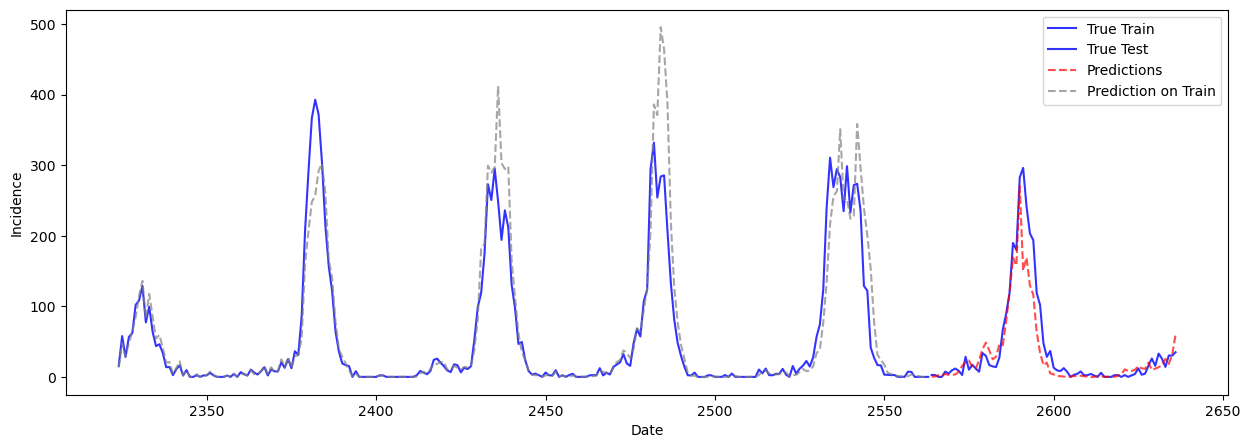

In [140]:
# Plot the results
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the true values
# ax.plot(plot['incValue'])
ax.plot(y_train.index, y_train, label="True Train", alpha=0.8, color='blue')
ax.plot(y_test.index, y_test, label="True Test", alpha=0.8, color='blue')
ax.plot(y_test.index, forecasts, label='Predictions', alpha=0.7, color='red', linestyle='--')
ax.plot(y_train.index, y_hat_train, label='Prediction on Train', alpha=0.7, color='grey', linestyle='--')


# Add labels and legend
ax.set_xlabel("Date")
ax.set_ylabel("Incidence")
ax.legend()

<h3>Exogenous Variables</h3>